<a href="https://colab.research.google.com/github/ivsanro1/Seedtag/blob/main/Seedtag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Author: Iván Sánchez Rodríguez
# Email: ivsanro1@gmail.com

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/exploration/
  inflating: dataset/exploration/59497  
  inflating: dataset/exploration/59846  
  inflating: dataset/exploration/59848  
  inflating: dataset/exploration/59849  
  inflating: dataset/exploration/59850  
  inflating: dataset/exploration/59870  
  inflating: dataset/exploration/59871  
  inflating: dataset/exploration/59872  
  inflating: dataset/exploration/59873  
  inflating: dataset/exploration/59874  
  inflating: dataset/exploration/59904  
  inflating: dataset/exploration/59905  
  inflating: dataset/exploration/59906  
  inflating: dataset/exploration/59907  
  inflating: dataset/exploration/59908  
  inflating: dataset/exploration/59909  
  inflating: dataset/exploration/59913  
  inflating: dataset/exploration/60103  
  inflating: dataset/exploration/60151  
  inflating: dataset/exploration/60153  
  inflating: dataset/exploration/60154  
  inflating: dataset/exploration/60155  
  inflating: dataset

In [ ]:
# Let's see what a random sample looks like
def read_doc(path):
  with open(path, 'r', encoding='latin1') as f:
    return f.read()

print(read_doc('/content/dataset/exploration/59497'))


In article <C4KvJF.4qo@well.sf.ca.us> metares@well.sf.ca.us (Tom Van Flandern) writes:
>crb7q@kelvin.seas.Virginia.EDU (Cameron Randale Bass) writes:
>> Bruce.Scott@launchpad.unc.edu (Bruce Scott) writes:
>>> "Existence" is undefined unless it is synonymous with "observable" in
>>> physics.
>> [crb] Dong ....  Dong ....  Dong ....  Do I hear the death-knell of
>> string theory?
>
>     I agree.  You can add "dark matter" and quarks and a lot of other
>unobservable, purely theoretical constructs in physics to that list,
>including the omni-present "black holes."
>
>     Will Bruce argue that their existence can be inferred from theory
>alone?  Then what about my original criticism, when I said "Curvature
>can only exist relative to something non-curved"?  Bruce replied:
>"'Existence' is undefined unless it is synonymous with 'observable' in
>physics.  We cannot observe more than the four dimensions we know about."
>At the moment I don't see a way to defend that statement and the
>exist

In [ ]:
# Seems like they are mails. We inspect another random sample to see if there's any format regularity
print(read_doc('/content/dataset/logistics/51119'))


In article <65974@mimsy.umd.edu>
mangoe@cs.umd.edu (Charley Wingate) writes:
 
>>Well, John has a quite different, not necessarily more elaborated theology.
>>There is some evidence that he must have known Luke, and that the content
>>of Q was known to him, but not in a 'canonized' form.
>
>This is a new argument to me.  Could you elaborate a little?
>
 
The argument goes as follows: Q-oid quotes appear in John, but not in
the almost codified way they were in Matthew or Luke. However, they are
considered to be similar enough to point to knowledge of Q as such, and
not an entirely different source.
 
 
>>Assuming that he knew Luke would obviously put him after Luke, and would
>>give evidence for the latter assumption.
>
>I don't think this follows.  If you take the most traditional attributions,
>then Luke might have known John, but John is an elder figure in either case.
>We're talking spans of time here which are well within the range of
>lifetimes.
 
We are talking date of texts her

In [ ]:
# Seems like quotes can be quite complex, since they can be distributed and nested along the whole mail
# Seems like they can be categorized and/or cleaned by checking the ">" prefix
#
# Anyway, we will just stick for a simple solution without too much processing and establish a baseline

# Create Dataset

In [ ]:
from pathlib import Path
from glob import glob
import pandas as pd

cwd = '/content/dataset'
list_paths_docs = [Path(p) for p in glob(cwd + '/*/*')]


df = pd.DataFrame({
    'txt': [read_doc(path_doc) for path_doc in list_paths_docs],
    'y': [path_doc.parent.stem for path_doc in list_paths_docs],
})

# Basic analysis

## Check class balance


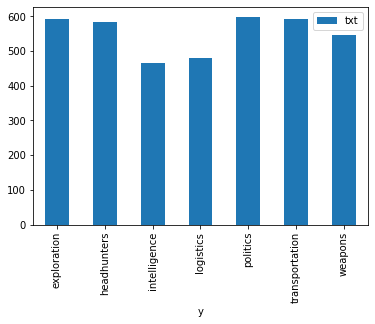

In [ ]:
# Let's get a glimpse of how imbalanced the classes are
df.groupby('y').count().plot.bar()
# Good! They are not extremely imbalanced

## Extract basic features for further analysis

In [ ]:
# Let's see the distribution of:
#   - Text length (chars)
#   - Text length (num tokens)
#   - Number of email addresses per doc
#   - Number of lines that are quotes per doc
#   - Ratio of quote lines per doc

# ... for each of the classes, to see if we could benefit from them as features for classification

In [ ]:
import re
regex_mailaddr = r'[\w\.-]+@[\w\.-]+(?:\.[\w]+)+'

def get_mail_addresses(text):
  '''
  Extracts with a regex the mail addresses given in a text
  '''
  return re.findall(regex_mailaddr, text, re.MULTILINE)

def repl_mail_addr(text, repl):
  '''
  Replaces all mail addresses in the text with a given `sub_str`
  '''
  return re.sub(pattern=regex_mailaddr, repl=repl, string=text, flags=re.MULTILINE)

def count_lines_start_with(text, prefix):
  lines = text.split('\n')
  return len([line for line in lines if line.startswith(prefix)])

### Process Text

In [ ]:
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

def process_txt(txt):
  txt = txt.lower() 
  txt = repl_mail_addr(txt, 'MAIL_ADDR') # Special token that encapsulates all mail addresses
  toks = [tok for tok in word_tokenize(txt) if
            tok not in string.punctuation and
            tok not in stopwords.words('english')] # Since some tokens are just punctuation-related

  txt = ' '.join(toks)
  return txt

df['txt_proc'] = df['txt'].apply(process_txt)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Stem

I am going to stem because my approach is not going to be word embedding based for simplicity. Since it's going to be a tfidf feature based, to reduce the starting dimensionality of the tfidf, I'm going to perform stemming to reduce the vocab size


In [ ]:
from nltk.stem import LancasterStemmer

stemmer = LancasterStemmer()
df['txt_proc_stem'] = df['txt_proc'].apply(lambda txt: ' '.join([stemmer.stem(tok) for tok in txt.split(' ')]))

## Extract features

In [ ]:
df['txt_len_char'] = df['txt'].apply(len)
df['txt_len_tok'] = df['txt'].apply(lambda txt: len(word_tokenize(txt)))
df['list_mail_addr'] = df['txt'].apply(lambda txt: get_mail_addresses(txt))
df['n_mail_addr'] = df['list_mail_addr'].apply(len)
df['n_lines_quotes'] = df['txt'].apply(lambda txt: count_lines_start_with(txt, '>'))
df['ratio_lines_quotes'] = df['txt'].apply(
    lambda txt: count_lines_start_with(txt, '>') / count_lines_start_with(txt, '')
    )

## Analysis

### Features' histograms (marginalized by class)

In [ ]:
import matplotlib.pyplot as plt

def plot_hist_custom_marginalized_y(
    df,
    col,
    bins,
    title,
    figsize=(10,10)
  ):

  fig, axes = plt.subplots(figsize=figsize)

  _ = df[col].hist(
      by=df['y'],
      bins=bins,
      ax=axes
  )

  _ = fig.suptitle(title, fontsize=16)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:357: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


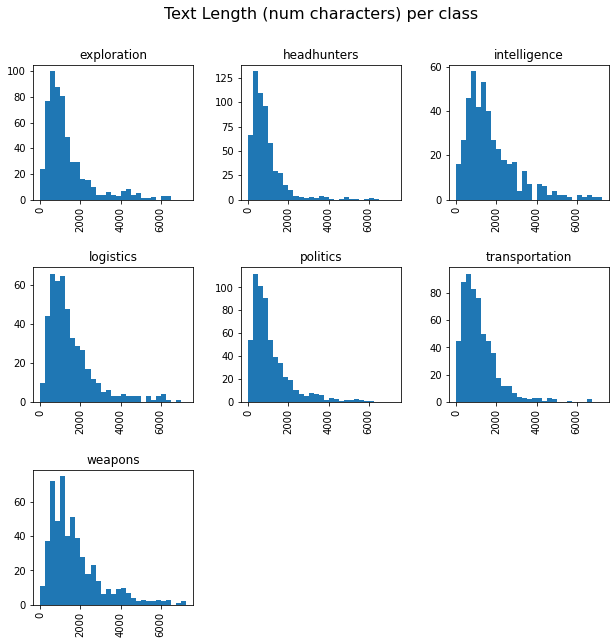

In [ ]:
plot_hist_custom_marginalized_y(
    df=df,
    col='txt_len_char',
    bins=[250*i for i in range(30)],
    title='Text Length (num characters) per class',
    figsize=(10,10)
)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:357: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


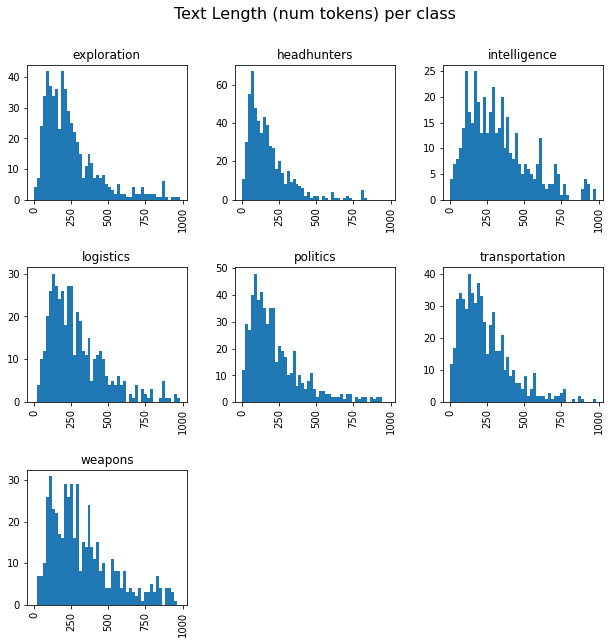

In [ ]:
plot_hist_custom_marginalized_y(
    df=df,
    col='txt_len_tok',
    bins=[20*i for i in range(50)],
    title='Text Length (num tokens) per class',
    figsize=(10,10)
)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:357: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


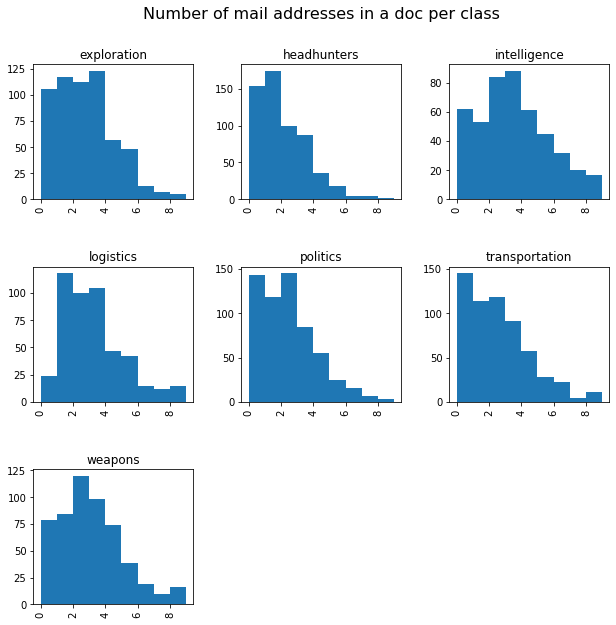

In [ ]:
plot_hist_custom_marginalized_y(
    df=df,
    col='n_mail_addr',
    bins=[1*i for i in range(10)],
    title='Number of mail addresses in a doc per class',
    figsize=(10,10)
)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:357: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


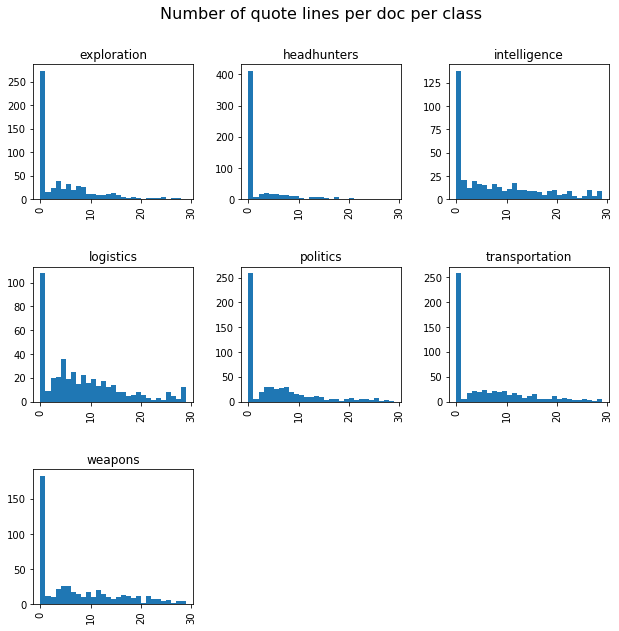

In [ ]:
plot_hist_custom_marginalized_y(
    df=df,
    col='n_lines_quotes',
    bins=[1*i for i in range(30)],
    title='Number of quote lines per doc per class',
    figsize=(10,10)
)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:357: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


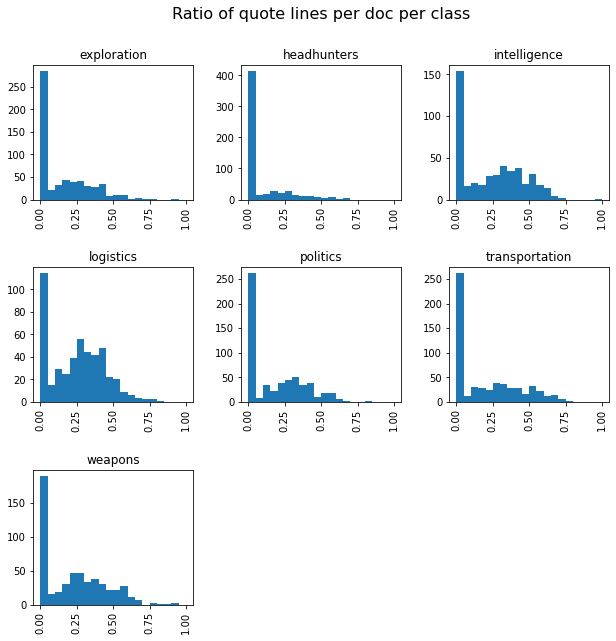

In [ ]:
plot_hist_custom_marginalized_y(
    df=df,
    col='ratio_lines_quotes',
    bins=[0.05*i for i in range(21)],
    title='Ratio of quote lines per doc per class',
    figsize=(10,10)
)

In [ ]:
### Most common words (marginalzied by class)

## Basic analysis conclusions

Although the class 'Intelligence' seems to be slightly discriminative given these kind of features, a priori we can see that there's not a lot of difference between the distribution of these features depending on the class, so although I can add these features, I don't expect them to have much of an impact on the classification performance

# Model definition

For the baseline model, I'm going to go for:

1.   Simple text preprocessing
2.   tfidf vectorization
3.   dim. reduc. (when the model needs it)
4.   Try several classic text classifiers such as

    4.1. Naive Bayes

    4.2. Neural Net

    4.3. Random Forest

    4.4. Extremely Randomized Trees

    4.5. Linear Support Vector Classifier

    4.6. Gradient Boosting Classifier


To see which one adjusts better to our data. I will use the default parameters of each model, and choose what I think it's the best model, given the results. After choosing what model I will be sticking to, I will tweak the parameters using a grid search to try to maximise the evaluation metrics.

Also, to ensure that we are objectively evaluating the models' performance, we are going to perform a Stratified 5 fold CV, obviously stratifying by 'y'

In [ ]:
import numpy as np

# Borrowed from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

MultinomialNB:

                precision    recall  f1-score   support

   exploration       0.93      0.92      0.93       474
   headhunters       0.90      0.96      0.93       467
  intelligence       0.98      0.79      0.88       372
     logistics       0.95      0.94      0.94       384
      politics       0.95      0.97      0.96       478
transportation       0.93      0.93      0.93       475
       weapons       0.88      0.96      0.92       437

      accuracy                           0.93      3087
     macro avg       0.93      0.92      0.93      3087
  weighted avg       0.93      0.93      0.93      3087



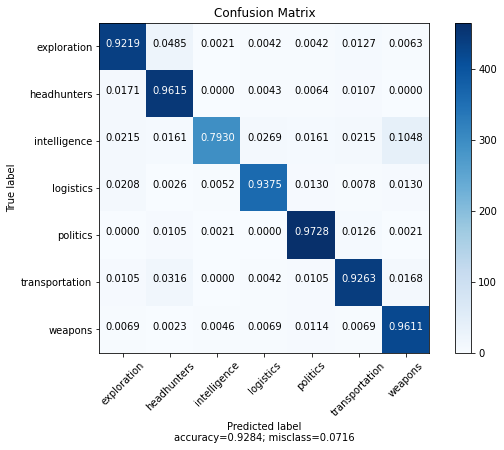


____________________________________________________

Cumulative EVR (1000 components): 0.8009850620035056
Cumulative EVR (1000 components): 0.8046422039384801
Cumulative EVR (1000 components): 0.8025020312844655
Cumulative EVR (1000 components): 0.8015202943112869
Cumulative EVR (1000 components): 0.8018009709043141
MLPClassifier:

                precision    recall  f1-score   support

   exploration       0.94      0.91      0.92       474
   headhunters       0.90      0.95      0.92       467
  intelligence       0.89      0.88      0.89       372
     logistics       0.96      0.92      0.94       384
      politics       0.92      0.96      0.94       478
transportation       0.92      0.92      0.92       475
       weapons       0.95      0.92      0.94       437

      accuracy                           0.93      3087
     macro avg       0.93      0.92      0.92      3087
  weighted avg       0.93      0.93      0.93      3087



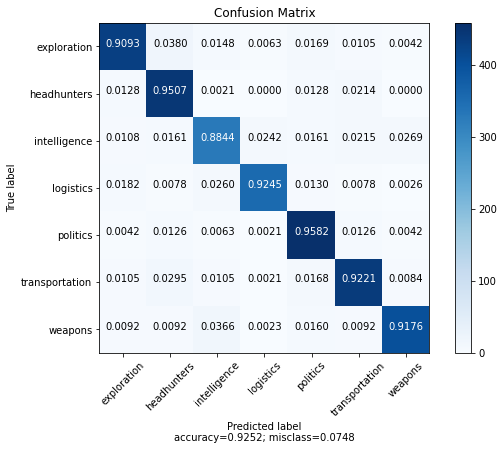


____________________________________________________

RandomForestClassifier:

                precision    recall  f1-score   support

   exploration       0.96      0.84      0.90       474
   headhunters       0.74      0.95      0.83       467
  intelligence       0.91      0.76      0.83       372
     logistics       0.94      0.88      0.91       384
      politics       0.87      0.93      0.90       478
transportation       0.88      0.86      0.87       475
       weapons       0.91      0.88      0.89       437

      accuracy                           0.88      3087
     macro avg       0.89      0.87      0.88      3087
  weighted avg       0.88      0.88      0.88      3087



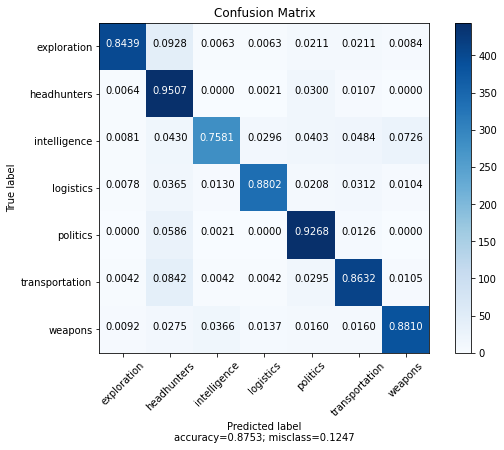


____________________________________________________

ExtraTreesClassifier:

                precision    recall  f1-score   support

   exploration       0.97      0.87      0.92       474
   headhunters       0.80      0.96      0.87       467
  intelligence       0.95      0.81      0.88       372
     logistics       0.96      0.91      0.94       384
      politics       0.91      0.95      0.93       478
transportation       0.89      0.90      0.90       475
       weapons       0.92      0.91      0.92       437

      accuracy                           0.91      3087
     macro avg       0.91      0.90      0.91      3087
  weighted avg       0.91      0.91      0.91      3087



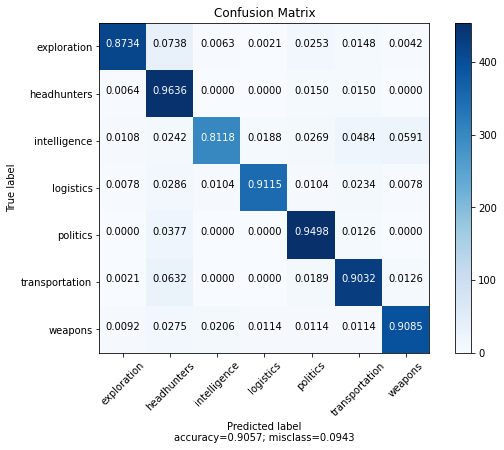


____________________________________________________

LinearSVC:

                precision    recall  f1-score   support

   exploration       0.95      0.94      0.95       474
   headhunters       0.92      0.97      0.95       467
  intelligence       0.92      0.87      0.89       372
     logistics       0.94      0.96      0.95       384
      politics       0.96      0.96      0.96       478
transportation       0.94      0.94      0.94       475
       weapons       0.95      0.93      0.94       437

      accuracy                           0.94      3087
     macro avg       0.94      0.94      0.94      3087
  weighted avg       0.94      0.94      0.94      3087



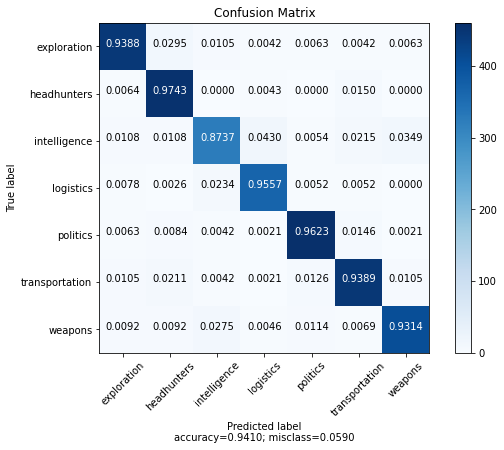


____________________________________________________

GradientBoostingClassifier:

                precision    recall  f1-score   support

   exploration       0.84      0.88      0.86       474
   headhunters       0.79      0.91      0.85       467
  intelligence       0.83      0.80      0.81       372
     logistics       0.92      0.86      0.89       384
      politics       0.90      0.88      0.89       478
transportation       0.85      0.84      0.84       475
       weapons       0.90      0.82      0.86       437

      accuracy                           0.86      3087
     macro avg       0.86      0.86      0.86      3087
  weighted avg       0.86      0.86      0.86      3087



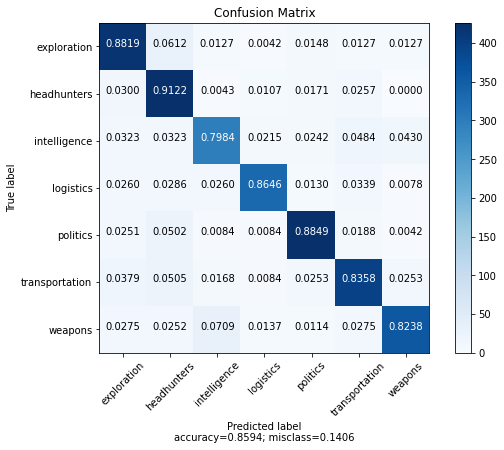


____________________________________________________



In [ ]:
# FEATURES
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# MODELS
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

# DATA & METRICS
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Keep an UNTOUCHABLE test set for the final eval (not even dev eval can be done on this one),
# to avoid overfitting on the parameter tweaking process, and to have a final estimation of our
# error rate in new and completely-unseen data
df_tr_ev, df_te = train_test_split(df, test_size=0.2, stratify=df['y'], random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_classes_to_try = [
    MultinomialNB,
    MLPClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    LinearSVC,
    GradientBoostingClassifier
]

for model_class in model_classes_to_try:
  # Create cumulative lists of seen labels and predictions on the evals splits of the rskf process.
  # These are used to make a one-pass evaluation at the end of the rskf.
  # Disclaimer: Doing it this way, we lose the capacity of getting some interesting metrics' stats,
  #             like mean/stdev, but I'm doing this way for simplicity.
  rskf_y = []
  rskf_y_hat = []

  # For each split in the SKF
  for tr_idx, te_idx in skf.split(X=df_tr_ev, y=df_tr_ev['y']):
    df_tr = df_tr_ev.iloc[tr_idx] # Train
    df_ev = df_tr_ev.iloc[te_idx] # Eval

    # Feature extractors are fitted within-splits of the rskf to avoid leaking knowledge between tr/te
    tfidf = TfidfVectorizer(
      ngram_range=(1,3),
      max_df=0.8, # Best practice is to set as ratio
      min_df=5, # Best practice is to set as a whole number
    )
    
    # Create a new, unfitted classifier
    # Class-specific params for class weights 
    # (not model-related, just stuff needed for sklearn's API) 
    if model_class == LinearSVC:
      clf = model_class(class_weight='balanced', random_state=42)
    elif model_class in [RandomForestClassifier, ExtraTreesClassifier]:
      clf = model_class(class_weight='balanced_subsample', random_state=42)
    else: 
      try:
        clf = model_class(random_state=42)
      except TypeError: # Some models (Multinomial NB) don't have random_state. I did it this way to generalize (code-wise)
        clf = model_class()

    X_tr_tfidf = tfidf.fit_transform(df_tr['txt_proc_stem'])
    X_ev_tfidf = tfidf.transform(df_ev['txt_proc_stem'])

    if type(clf) != MLPClassifier:
      clf.fit(X=X_tr_tfidf, y=df_tr['y'])
      y_hat_tr = clf.predict(X_tr_tfidf)
      y_hat_ev = clf.predict(X_ev_tfidf)
    else: # NN needs lower dimensionality, because it's dense, not like the other models
      n_components = 1000 # I tweaked n_components until Cumulative EVR was something around 80%
      tsvd = TruncatedSVD(n_components=n_components)
      X_tr_tsvd = tsvd.fit_transform(X_tr_tfidf)
      X_ev_tsvd = tsvd.transform(X_ev_tfidf)
      # Print cumulative EVR so ensure we are not missing a lot of variance in the features
      # (we want to keep feature variability up to a point. I think something around 80% is OK
      print(f'Cumulative EVR ({n_components} components): {tsvd.explained_variance_ratio_.cumsum()[-1]}') 
      clf.fit(X=X_tr_tsvd, y=df_tr['y'])
      y_hat_tr = clf.predict(X_tr_tsvd)
      y_hat_ev = clf.predict(X_ev_tsvd)

    rskf_y.extend(df_ev['y'])
    rskf_y_hat.extend(y_hat_ev)

  print(model_class.__name__ + ':\n')
  print(classification_report(rskf_y, rskf_y_hat))
  cm = confusion_matrix(rskf_y, rskf_y_hat)
  plot_confusion_matrix(
      cm=cm,
      normalize=True,
      target_names=sorted(np.unique(df['y'])),
      title='Confusion Matrix'
  )
  print('\n____________________________________________________\n')

## Select model and search params

The best model so far seems LinearSVC, although NN  and Naive Bayes do a very good job too.

If I wanted to further improve the results (in the future steps, not done in this interview) with a fully connected using TensorFlow, for example, I would go for NN, but for the conclusion of this interview, I'm going to stick with the LinearSVC

Cumulative EVR (1000 components): 0.8009526671019113
Cumulative EVR (1000 components): 0.8046331109218458
Cumulative EVR (1000 components): 0.8025295220127111
Cumulative EVR (1000 components): 0.8015674344561219
Cumulative EVR (1000 components): 0.8017579053364774
Params:
	C: 0.1
	loss: hinge
	lda: True
                precision    recall  f1-score   support

   exploration       0.96      0.89      0.93       474
   headhunters       0.88      0.97      0.92       467
  intelligence       0.95      0.82      0.88       372
     logistics       0.89      0.95      0.92       384
      politics       0.95      0.98      0.96       478
transportation       0.94      0.92      0.93       475
       weapons       0.92      0.93      0.93       437

      accuracy                           0.93      3087
     macro avg       0.93      0.92      0.92      3087
  weighted avg       0.93      0.93      0.93      3087



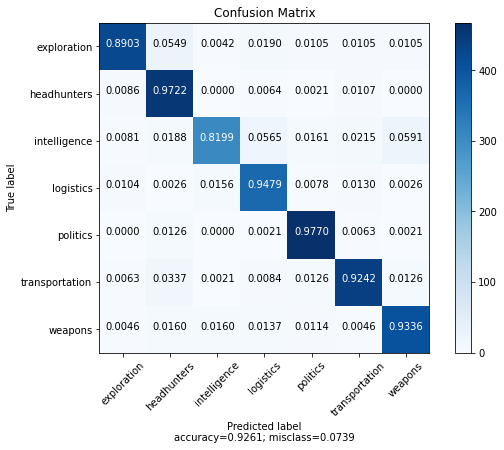


____________________________________________________

Params:
	C: 0.1
	loss: hinge
	lda: False
                precision    recall  f1-score   support

   exploration       0.97      0.90      0.93       474
   headhunters       0.88      0.97      0.92       467
  intelligence       0.95      0.84      0.89       372
     logistics       0.90      0.95      0.93       384
      politics       0.95      0.97      0.96       478
transportation       0.95      0.93      0.94       475
       weapons       0.93      0.94      0.93       437

      accuracy                           0.93      3087
     macro avg       0.93      0.93      0.93      3087
  weighted avg       0.93      0.93      0.93      3087



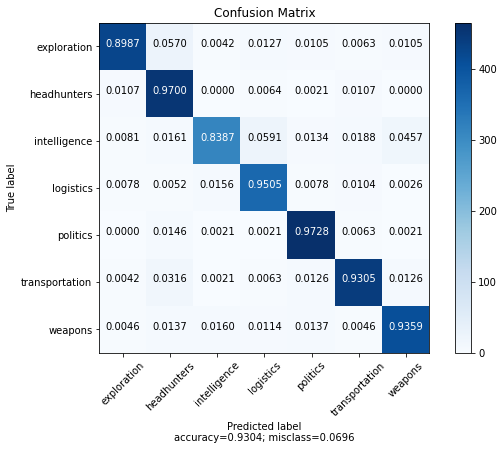


____________________________________________________

Cumulative EVR (1000 components): 0.8010164273803471
Cumulative EVR (1000 components): 0.8046519171140846
Cumulative EVR (1000 components): 0.8024917802846824
Cumulative EVR (1000 components): 0.8015625467078986
Cumulative EVR (1000 components): 0.8017723751935059
Params:
	C: 0.1
	loss: squared_hinge
	lda: True
                precision    recall  f1-score   support

   exploration       0.97      0.91      0.94       474
   headhunters       0.87      0.97      0.92       467
  intelligence       0.93      0.86      0.90       372
     logistics       0.92      0.95      0.93       384
      politics       0.96      0.97      0.96       478
transportation       0.94      0.93      0.93       475
       weapons       0.95      0.93      0.94       437

      accuracy                           0.93      3087
     macro avg       0.93      0.93      0.93      3087
  weighted avg       0.93      0.93      0.93      3087



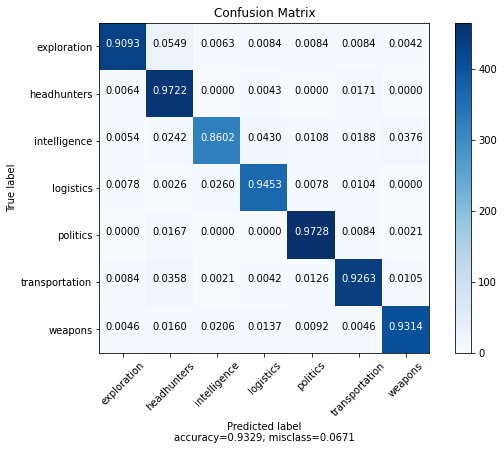


____________________________________________________

Params:
	C: 0.1
	loss: squared_hinge
	lda: False
                precision    recall  f1-score   support

   exploration       0.97      0.92      0.94       474
   headhunters       0.88      0.98      0.93       467
  intelligence       0.94      0.86      0.89       372
     logistics       0.93      0.95      0.94       384
      politics       0.96      0.97      0.97       478
transportation       0.95      0.93      0.94       475
       weapons       0.95      0.94      0.94       437

      accuracy                           0.94      3087
     macro avg       0.94      0.94      0.94      3087
  weighted avg       0.94      0.94      0.94      3087



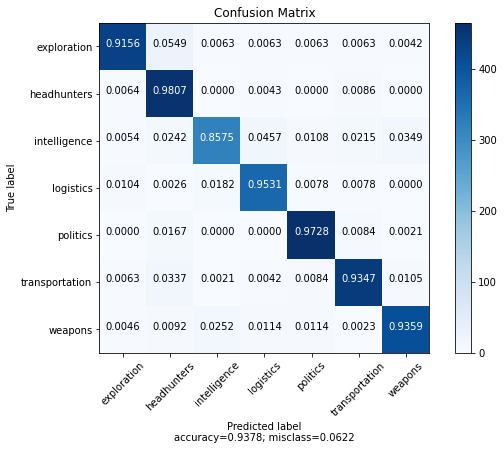


____________________________________________________

Cumulative EVR (1000 components): 0.8009585208731449
Cumulative EVR (1000 components): 0.8046773626148539
Cumulative EVR (1000 components): 0.8025146550717452
Cumulative EVR (1000 components): 0.8015287725496992
Cumulative EVR (1000 components): 0.8017514572104609
Params:
	C: 1
	loss: hinge
	lda: True
                precision    recall  f1-score   support

   exploration       0.96      0.93      0.95       474
   headhunters       0.91      0.97      0.94       467
  intelligence       0.94      0.86      0.90       372
     logistics       0.92      0.96      0.94       384
      politics       0.95      0.96      0.95       478
transportation       0.94      0.94      0.94       475
       weapons       0.95      0.93      0.94       437

      accuracy                           0.94      3087
     macro avg       0.94      0.94      0.94      3087
  weighted avg       0.94      0.94      0.94      3087



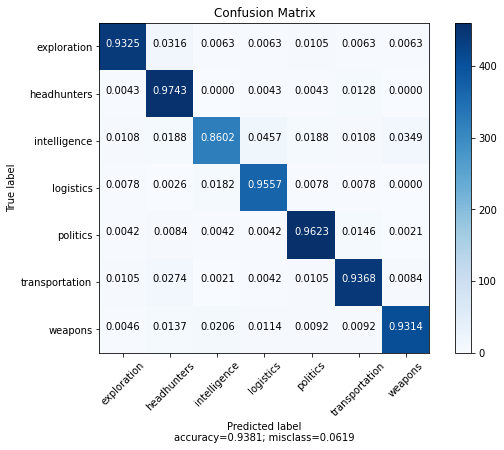


____________________________________________________

Params:
	C: 1
	loss: hinge
	lda: False
                precision    recall  f1-score   support

   exploration       0.96      0.93      0.94       474
   headhunters       0.92      0.97      0.95       467
  intelligence       0.92      0.87      0.90       372
     logistics       0.94      0.96      0.95       384
      politics       0.96      0.96      0.96       478
transportation       0.94      0.94      0.94       475
       weapons       0.94      0.93      0.94       437

      accuracy                           0.94      3087
     macro avg       0.94      0.94      0.94      3087
  weighted avg       0.94      0.94      0.94      3087



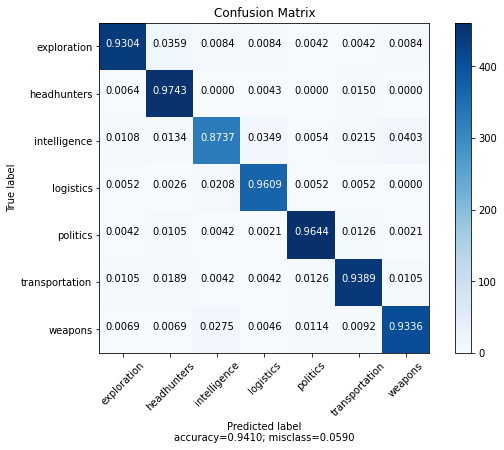


____________________________________________________

Cumulative EVR (1000 components): 0.8009214501148766
Cumulative EVR (1000 components): 0.8046673458484545
Cumulative EVR (1000 components): 0.8024906912454088
Cumulative EVR (1000 components): 0.801523042160329
Cumulative EVR (1000 components): 0.8018038670747857
Params:
	C: 1
	loss: squared_hinge
	lda: True
                precision    recall  f1-score   support

   exploration       0.95      0.93      0.94       474
   headhunters       0.92      0.97      0.95       467
  intelligence       0.92      0.87      0.90       372
     logistics       0.92      0.95      0.94       384
      politics       0.96      0.96      0.96       478
transportation       0.94      0.94      0.94       475
       weapons       0.94      0.93      0.94       437

      accuracy                           0.94      3087
     macro avg       0.94      0.94      0.94      3087
  weighted avg       0.94      0.94      0.94      3087



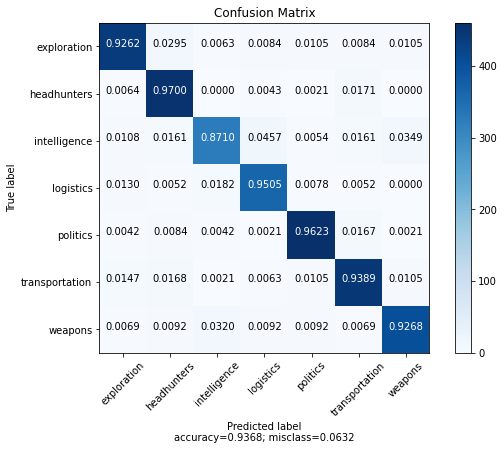


____________________________________________________

Params:
	C: 1
	loss: squared_hinge
	lda: False
                precision    recall  f1-score   support

   exploration       0.95      0.94      0.95       474
   headhunters       0.92      0.97      0.95       467
  intelligence       0.92      0.87      0.89       372
     logistics       0.94      0.96      0.95       384
      politics       0.96      0.96      0.96       478
transportation       0.94      0.94      0.94       475
       weapons       0.95      0.93      0.94       437

      accuracy                           0.94      3087
     macro avg       0.94      0.94      0.94      3087
  weighted avg       0.94      0.94      0.94      3087



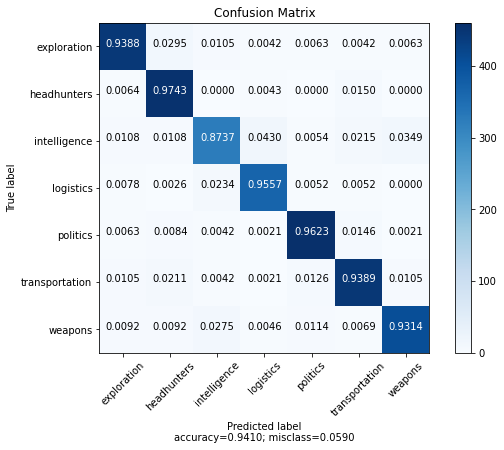


____________________________________________________

Cumulative EVR (1000 components): 0.8009639792454512


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Cumulative EVR (1000 components): 0.8046473379120068
Cumulative EVR (1000 components): 0.8025022844148442
Cumulative EVR (1000 components): 0.8015443299744812
Cumulative EVR (1000 components): 0.8017059778198118
Params:
	C: 10
	loss: hinge
	lda: True
                precision    recall  f1-score   support

   exploration       0.94      0.92      0.93       474
   headhunters       0.92      0.96      0.94       467
  intelligence       0.92      0.87      0.89       372
     logistics       0.92      0.93      0.93       384
      politics       0.94      0.95      0.95       478
transportation       0.93      0.93      0.93       475
       weapons       0.94      0.93      0.93       437

      accuracy                           0.93      3087
     macro avg       0.93      0.93      0.93      3087
  weighted avg       0.93      0.93      0.93      3087



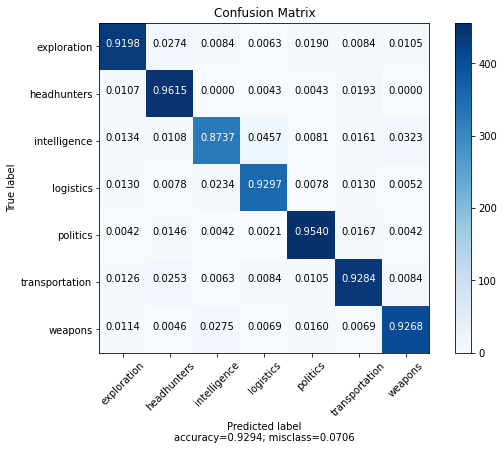


____________________________________________________

Params:
	C: 10
	loss: hinge
	lda: False
                precision    recall  f1-score   support

   exploration       0.95      0.92      0.94       474
   headhunters       0.91      0.96      0.94       467
  intelligence       0.89      0.88      0.88       372
     logistics       0.95      0.95      0.95       384
      politics       0.95      0.96      0.95       478
transportation       0.93      0.93      0.93       475
       weapons       0.94      0.92      0.93       437

      accuracy                           0.93      3087
     macro avg       0.93      0.93      0.93      3087
  weighted avg       0.93      0.93      0.93      3087



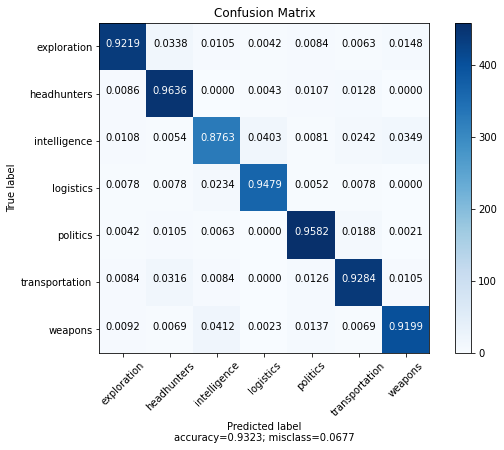


____________________________________________________

Cumulative EVR (1000 components): 0.8009665716509332
Cumulative EVR (1000 components): 0.8046348331536267
Cumulative EVR (1000 components): 0.8025235510936898
Cumulative EVR (1000 components): 0.8015502871176264
Cumulative EVR (1000 components): 0.8017621633114779
Params:
	C: 10
	loss: squared_hinge
	lda: True
                precision    recall  f1-score   support

   exploration       0.95      0.93      0.94       474
   headhunters       0.92      0.96      0.94       467
  intelligence       0.93      0.87      0.90       372
     logistics       0.93      0.94      0.93       384
      politics       0.93      0.96      0.95       478
transportation       0.93      0.93      0.93       475
       weapons       0.94      0.93      0.94       437

      accuracy                           0.93      3087
     macro avg       0.93      0.93      0.93      3087
  weighted avg       0.93      0.93      0.93      3087



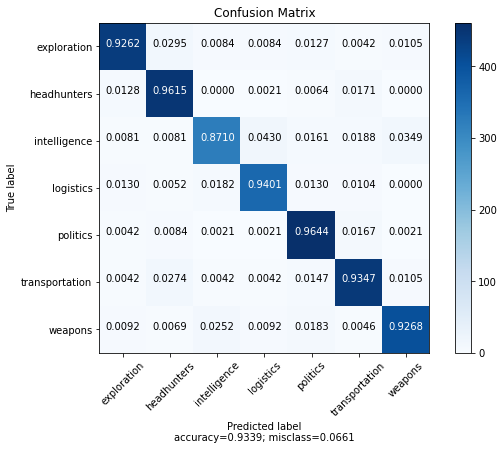


____________________________________________________

Params:
	C: 10
	loss: squared_hinge
	lda: False
                precision    recall  f1-score   support

   exploration       0.96      0.93      0.94       474
   headhunters       0.91      0.97      0.94       467
  intelligence       0.89      0.88      0.88       372
     logistics       0.94      0.95      0.94       384
      politics       0.95      0.96      0.95       478
transportation       0.94      0.93      0.93       475
       weapons       0.95      0.92      0.94       437

      accuracy                           0.93      3087
     macro avg       0.93      0.93      0.93      3087
  weighted avg       0.93      0.93      0.93      3087



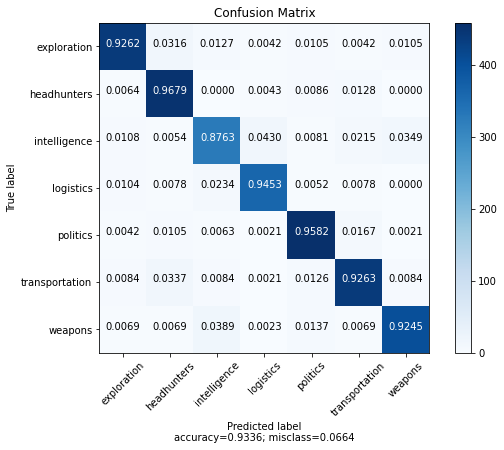


____________________________________________________



In [221]:
# I'm not using GridSearchCV because this way I have more flexibility
# with fitting the feature extractors for the splits, without the need of a sklearn pipeline

for C in [0.1, 1, 10]:
  for loss in ['hinge', 'squared_hinge']:
    for lda in True, False: # We are going to try LDA even if it's not a Neural Network to see if it can improve the results
      rskf_y = []
      rskf_y_hat = []

      # For each split in the SKF
      for tr_idx, te_idx in skf.split(X=df_tr_ev, y=df_tr_ev['y']):
        df_tr = df_tr_ev.iloc[tr_idx] # Train
        df_ev = df_tr_ev.iloc[te_idx] # Eval

        # Feature extractors are fitted within-splits of the rskf to avoid leaking knowledge between tr/te
        tfidf = TfidfVectorizer(
          ngram_range=(1,3),
          max_df=0.8,
          min_df=5,
        )
        
        clf = LinearSVC(
            class_weight='balanced',
            C=C,
            loss=loss,
            max_iter=2000 # Increased number of iterations so we ensure it has converged, because I saw that sometimes it would not converge with the default 1000
        )

        X_tr_tfidf = tfidf.fit_transform(df_tr['txt_proc_stem'])
        X_ev_tfidf = tfidf.transform(df_ev['txt_proc_stem'])

        if not lda:
          clf.fit(X=X_tr_tfidf, y=df_tr['y'])
          y_hat_tr = clf.predict(X_tr_tfidf)
          y_hat_ev = clf.predict(X_ev_tfidf)
        else:
          n_components = 1000
          tsvd = TruncatedSVD(n_components=n_components)
          X_tr_tsvd = tsvd.fit_transform(X_tr_tfidf)
          X_ev_tsvd = tsvd.transform(X_ev_tfidf)
          print(f'Cumulative EVR ({n_components} components): {tsvd.explained_variance_ratio_.cumsum()[-1]}') 
          clf.fit(X=X_tr_tsvd, y=df_tr['y'])
          y_hat_tr = clf.predict(X_tr_tsvd)
          y_hat_ev = clf.predict(X_ev_tsvd)

        rskf_y.extend(df_ev['y'])
        rskf_y_hat.extend(y_hat_ev)

      print(f'Params:\n\tC: {C}\n\tloss: {loss}\n\tlda: {lda}')
      print(classification_report(rskf_y, rskf_y_hat))
      cm = confusion_matrix(rskf_y, rskf_y_hat)
      plot_confusion_matrix(
          cm=cm,
          normalize=True,
          target_names=sorted(np.unique(df['y'])),
          title='Confusion Matrix'
      )
      print('\n____________________________________________________\n')


Best params configs with same accuracy (94.10 %)
>	C: 1
>
>	loss: squared_hinge
>
>	lda: False

and 

>	C: 1
>
>	loss: hinge
>
>	lda: False

Seeing the results, we can appreciate a relatively low recall on the class 'intelligence'. One reason of this could be the diversity of the vocabulary of that class, a problem that could be reduced if we used semantic embeddings that capture the meaning of the words instead of relying in count-based methods as we did using TFIDF. For future work, I would try a pre-trained embedding like GloVe to encode the texts as a feature (e.g. mean of embeddings), or as a sequence and feed it to a CNN or LSTM (I would use TF 2.x for this), or even make an ensemble or stack of classifiers, each one with different features.

# Train selected model and params with all data

In [224]:
tfidf = TfidfVectorizer(
  ngram_range=(1,3),
  max_df=0.8,
  min_df=5,
)

clf = LinearSVC(
    class_weight='balanced',
    C=1,
    max_iter=2000
)

X_tr_ev_tfidf = tfidf.fit_transform(df_tr_ev['txt_proc_stem'])

clf.fit(X=X_tr_ev_tfidf, y=df_tr_ev['y'])
y_hat_tr_ev = clf.predict(X_tr_ev_tfidf)

# Final Test metrics

                precision    recall  f1-score   support

   exploration       1.00      0.95      0.97       119
   headhunters       0.96      0.99      0.97       117
  intelligence       0.97      0.97      0.97        93
     logistics       0.99      0.98      0.98        96
      politics       0.98      0.99      0.99       119
transportation       0.98      0.98      0.98       119
       weapons       0.95      0.96      0.95       109

      accuracy                           0.98       772
     macro avg       0.98      0.98      0.98       772
  weighted avg       0.98      0.98      0.98       772



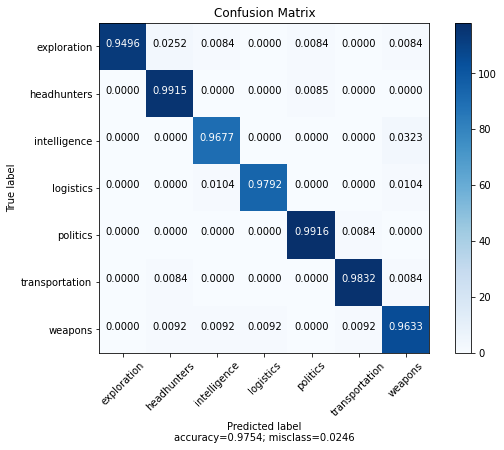

In [225]:
X_te_tfidf = tfidf.transform(df_te['txt_proc_stem'])
y_hat_te = clf.predict(X_te_tfidf)

print(classification_report(df_te['y'], y_hat_te))
cm = confusion_matrix(df_te['y'], y_hat_te)
plot_confusion_matrix(
    cm=cm,
    normalize=True,
    target_names=sorted(np.unique(df['y'])),
    title='Confusion Matrix'
)

## Conclusions of test metrics

It makes sense that it could be that the test metrics are better than Stratified KFold CV, since CV is more robust statistically speaking, and this test split out of the CV could have easy samples (i.e. I had 'luck' with the test split)

In [229]:
# Just to ensure there's no leak
assert len(df_te[df_te['txt_proc_stem'].apply(lambda txt: txt in df_tr_ev['txt_proc_stem'])]) == 0